<a href="https://colab.research.google.com/github/Mi1kDev/CST3133_CW/blob/main/CST3133_CourseWork_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing and Deep Learning Coursework Part 2

Connecting the project to google drive for easy members access

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2.1 Text Dataset Selection and Preprocessing


Importing core python libraries
*   pandas for dataset manipulation
*   numpy for mathematical processes
*   pyplot and seaborn for data visualization







In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

nlp_dataset = pd.read_csv("/content/drive/MyDrive/CST3133_CW/datasets/IMDB Dataset.csv")
nlp_dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Display general information breakdown of the dataset

In [3]:
nlp_dataset.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
nlp_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### Preprocessing the reviews


Reviewing the dataset structure for preprocessing

In [5]:
nlp_dataset.shape

(50000, 2)

In [6]:
nlp_dataset.isnull().sum()

,0
review,0
sentiment,0


In [7]:
nlp_dataset.isnull().sum().sum()

0

Checking for duplicates and removing them

In [8]:
nlp_dataset.duplicated().sum()

418

In [9]:
nlp_dataset.drop_duplicates(inplace=True)
nlp_dataset.shape

(49582, 2)

Importing and downloading all the necessary libraries to tokenise the reviews

In [10]:
# Regular Expressions Library to Clean the data
import re
# Natural Language Toolkit Library to Preprocess the data
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Downhload the necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

Function to determine the part-of-speech(POS) tag for each word.

In [11]:
def get_wordnet_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  # post_tag access = [Tupple][POS Tag][First Letter POS Tag]
  tag_dict = {
      "J": wordnet.ADJ, # Adjectives
      "N": wordnet.NOUN, # Nouns
      "V": wordnet.VERB, # Verbs
      "R": wordnet.ADV # Adverb
      }
  return tag_dict.get(tag, wordnet.NOUN)

Cleaning the dataset
*   Turning each word to lower case
*   Removing HTML tags
*   Tokenising the words
*   Removing Stopwords
*   Applying lemmatization







In [12]:
def preprocess_text(review):
  review = review.lower()
  review = re.sub(r'<[^>]+>', '', review)
  review = re.sub(r'[^a-zA-Z0-9]', ' ', review)
  tokens = word_tokenize(review)
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]

  return " " .join(tokens)

Extracting the tokens of the review and target labels as binary:

In [13]:
nlp_tokenised_reviews = []
nlp_sentiment_labels = []

for index, row in nlp_dataset.iterrows():
  nlp_tokenised_reviews.append(preprocess_text(row['review']))
  nlp_sentiment_labels.append( 1 if row['sentiment'] == 'positive' else 0)

print(nlp_tokenised_reviews[:5])
print(nlp_sentiment_labels[:5])

['one reviewer mention watch 1 oz episode hooked right exactly happen first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word call oz nickname give oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture paint mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watch developed taste oz get accustom high level graphic violence violence injustice crooked guard sell nickel inmate kill order get away well mannered middle class inmate turn prison bitch due lack street skill prison experience watch oz may become comforta

Importing Google's Word2Vec as Pre-trained Embedding Model for feature representation.

In [14]:
!pip install gensim
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Function to generate numerical representation (embedding) for a string of tokens from a review

In [15]:
def get_sentence_embedding(sentence, model, vector_size = 300, max_len = 10):
  tokens = sentence.split()
  # Storing the numerical vectors of the tokens that are valid
  token_vectors = []
  valid_tokens = [token for token in tokens if token in model.key_to_index]
  # Returning a zero vector if no valid tokens are found
  if not valid_tokens:
    return np.zeros(vector_size)
  for token in valid_tokens:
    if token in model.key_to_index:
      token_vectors.append(model[token])
  # Padding to fix the length
  if len(token_vectors) < max_len:
    padding = [np.zeros(vector_size)] * (max_len - len(token_vectors))
    token_vectors.extend(padding)
  else:
    token_vectors = token_vectors[:max_len]

  # Returning the embeddings
  return np.array(token_vectors)

Extracting the embeddings for each review

In [16]:
nlp_embeddings = []
for review in nlp_tokenised_reviews:
  sentence_embedding = get_sentence_embedding(review, word2vec_model)
  nlp_embeddings.append(sentence_embedding)
#  Converting the embeddings and sentiment binary labels to NumPy array for the ML Model
nlp_embeddings = np.array(nlp_embeddings)
nlp_sentiment_labels = np.array(nlp_sentiment_labels)
print(nlp_embeddings.shape)
print(nlp_sentiment_labels.shape)

(49582, 10, 300)
(49582,)


In [17]:
MAX_LEN = 10
VECTOR_SIZE = 300

## 1.2.2 Deep Learning Model Implementation


Design and train a neural network, e.g., RNN, LSTM for a text-based task, e.g., sentiment analysis.

Clearly explain the model architecture, e.g., embedding layers, hidden layers, activation functions, and
hyperparameter tuning

###Design and Train Neural Network using Reccurent Neural Network (RNN) ###

In [19]:
# importing the necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

### Developing RNN Model ###

In [20]:
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(nlp_embeddings, nlp_sentiment_labels, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(39665, 10, 300)
(9917, 10, 300)
(39665,)
(9917,)


In [21]:
# impementing RNN model
model = Sequential()
model.add(SimpleRNN(units=128, input_shape=(MAX_LEN, VECTOR_SIZE), return_sequences=False))

# using dropout for regularisation of overfitting
model.add(Dropout(0.3))

# using Rectified Linear Unit which helps vanishing the gradient problem and making the module more efficient
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Executing the model and Training it ###


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          54,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,233 (247.00 KB)

 Trainable params: 63,233 (247.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.6390 - loss: 0.6318 - val_accuracy: 0.6925 - val_loss: 0.5915
Epoch 2/30
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.6924 - loss: 0.5756 - val_accuracy: 0.6912 - val_loss: 0.5775
Epoch 3/30
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6993 - loss: 0.5644 - val_accuracy: 0.6940 - val_loss: 0.5678
Epoch 4/30
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7156 - loss: 0.5486 - val_accuracy: 0.6929 - val_loss: 0.5683
Epoch 5/30
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7248 - loss: 0.5322 - val_accuracy: 0.7030 - val_loss: 0.5668
Epoch 6/30
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7329 - loss: 0.5257 - val_accuracy: 0.6952 - val_loss: 0.5696
Epoch 7/30
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7441 - loss: 0.5102 - val_accuracy: 0.6853 - val_loss: 0.5913
Epoch 8/30
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7469 - los

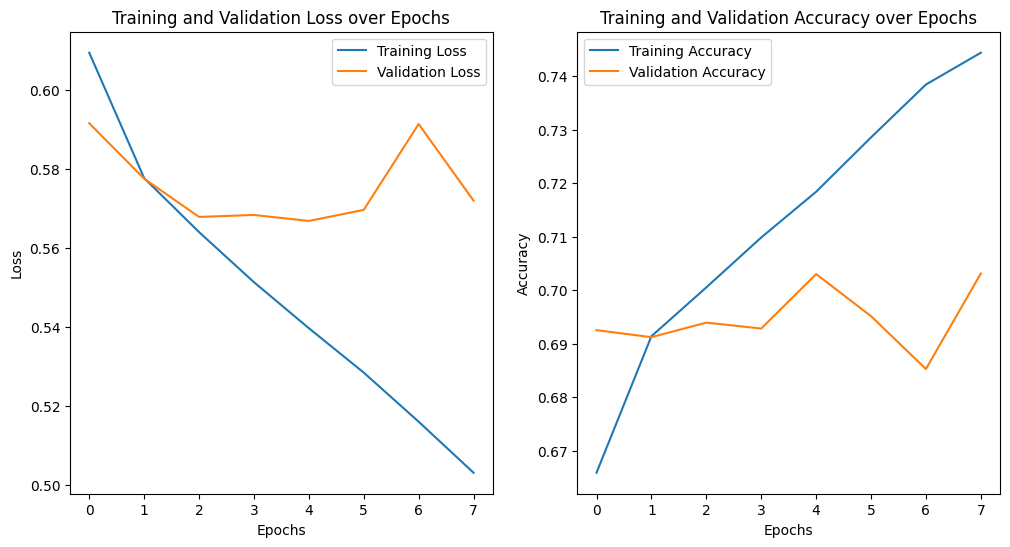

In [22]:
# executing RNN
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# importing earlystopping for preventing training and overfittings if occurs
from tensorflow.keras.callbacks import EarlyStopping
early_Stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# now train the model and add it to the history
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test), callbacks=[early_Stopping])


# plot the trained history for visualisation
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

plt.show()

## 1.2.3 Evaluation and Insights


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Use evaluation metrics, e.g., accuracy, precision, recall, loss curves.

Provide visualizations, e.g., learning curves, confusion matrices, to explain findings, where possible.

Highlight strengths, limitations and areas for improvement.

310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


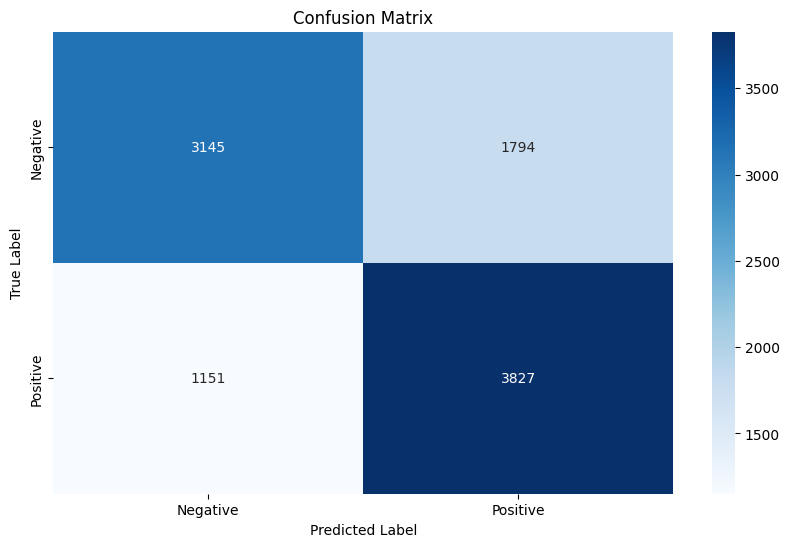

Accuracy: 0.7030351920943834
Precision: 0.6808397082369685
Recall: 0.7687826436319807
F1 Score: 0.7221435984526842


In [24]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
f1 = f1_score(y_test, predictions)